In [1]:
import time

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"using device {device}")

import matplotlib.pyplot as plt
import numpy as np

using device cpu


In [2]:
path = !pwd
path = path[0]
print(path)

/Users/andreas/repos/DD2424project


### setup data

In [3]:
torchvision.datasets.CIFAR10(path,download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /Users/andreas/repos/DD2424project
    Transforms (if any): None
    Target Transforms (if any): None

In [4]:
f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = torchvision.datasets.CIFAR10(path, transform=transform)

### ResNet-56
#### https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [5]:

def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [15]:
def validateFunc(batches):
    valacc = []
    
    resnet.eval()

    for i, (images, targets) in enumerate(val_loader):
        if i >= batches:
            break

        t = time.time()
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, targets)

        valacc = valacc + [get_xent_acc(prediction, targets)]
        
    resnet.train()
    
    return valacc

### create loss function 
#### https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [7]:
loss_xent = nn.CrossEntropyLoss()
loss_mse  = nn.MSELoss()

### need to turn labels into one-hot encoding to calculate accuracy

In [8]:
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 

### play with forward and backwards pass

In [9]:
%%capture
# Configure
resnet = ResNet(BasicBlock,[9,9,9])
batch_size = 128
optimizer = optim.SGD(resnet.parameters(),
                      lr=0.1,
                      momentum=0.9,
                      weight_decay=1e-4)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path, train=True, transform=transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(path, train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True)
if cuda_available: resnet.cuda()

In [10]:
start    = time.time()
n_epoch  = 1
accuracy = [] 
loss     = []
valacc   = []
validationInterval = 5

resnet.train()

for epoch in range(n_epoch):
    data_iterator = iter(data_loader)
    for i, (images, labels) in enumerate(data_iterator):
        t = time.time()
        
        f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
        if cuda_available: 
            images = images.cuda()
            labels = labels.cuda()
            
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, labels)
        
        accuracy = accuracy + [get_xent_acc(prediction, labels)]
        loss     = loss + [output]
        
        optimizer.zero_grad()
        output.backward() # calculates gradients 
        optimizer.step()  # updates weights
        
        print(f"epoch {i:3d}/{len(data_iterator)} t {time.time()-t:.3f} accuracy {accuracy[len(accuracy)-1]:.4f}")
        
        if i % validationInterval == 0:
            print(f"    accuracy {validateFunc(1)[0]:.7f}")
        
    print(f"""time passed after training {epoch} epochs is {time.time()-start} seconds""")

epoch   0/391 t 3.052 accuracy 0.1484
    accuracy 0.1328125
epoch   1/391 t 2.904 accuracy 0.1094
epoch   2/391 t 2.882 accuracy 0.1406
epoch   3/391 t 2.888 accuracy 0.1016
epoch   4/391 t 2.917 accuracy 0.1172
epoch   5/391 t 2.882 accuracy 0.1562
    accuracy 0.0390625
epoch   6/391 t 2.903 accuracy 0.1953
epoch   7/391 t 2.964 accuracy 0.1328
epoch   8/391 t 2.856 accuracy 0.1562
epoch   9/391 t 2.948 accuracy 0.1094
epoch  10/391 t 2.876 accuracy 0.1641
    accuracy 0.1562500
epoch  11/391 t 2.942 accuracy 0.1641
epoch  12/391 t 2.869 accuracy 0.2422
epoch  13/391 t 2.928 accuracy 0.2266
epoch  14/391 t 2.930 accuracy 0.2109
epoch  15/391 t 2.877 accuracy 0.2031
    accuracy 0.2031250
epoch  16/391 t 2.896 accuracy 0.1016
epoch  17/391 t 2.945 accuracy 0.1875
epoch  18/391 t 2.920 accuracy 0.1562
epoch  19/391 t 3.201 accuracy 0.1953
epoch  20/391 t 2.915 accuracy 0.1328
    accuracy 0.1093750
epoch  21/391 t 2.936 accuracy 0.2422
epoch  22/391 t 2.989 accuracy 0.1797
epoch  23/3

epoch 192/391 t 2.913 accuracy 0.4688
epoch 193/391 t 3.135 accuracy 0.4219
epoch 194/391 t 3.266 accuracy 0.4297
epoch 195/391 t 2.941 accuracy 0.4844
    accuracy 0.2500000
epoch 196/391 t 3.759 accuracy 0.4062
epoch 197/391 t 2.934 accuracy 0.4141
epoch 198/391 t 2.915 accuracy 0.4375
epoch 199/391 t 2.978 accuracy 0.3828
epoch 200/391 t 2.955 accuracy 0.4531
    accuracy 0.3125000
epoch 201/391 t 2.970 accuracy 0.4609
epoch 202/391 t 2.887 accuracy 0.3828
epoch 203/391 t 2.964 accuracy 0.4688
epoch 204/391 t 2.921 accuracy 0.5156
epoch 205/391 t 2.883 accuracy 0.5312
    accuracy 0.4687500
epoch 206/391 t 2.897 accuracy 0.4844
epoch 207/391 t 2.918 accuracy 0.4766
epoch 208/391 t 2.963 accuracy 0.4531
epoch 209/391 t 2.893 accuracy 0.3984
epoch 210/391 t 2.975 accuracy 0.5234
    accuracy 0.4140625
epoch 211/391 t 2.909 accuracy 0.4844
epoch 212/391 t 2.937 accuracy 0.5156
epoch 213/391 t 2.885 accuracy 0.5156
epoch 214/391 t 2.904 accuracy 0.4375
epoch 215/391 t 2.939 accuracy 0.5

epoch 385/391 t 3.053 accuracy 0.5703
    accuracy 0.5390625
epoch 386/391 t 2.978 accuracy 0.5312
epoch 387/391 t 2.959 accuracy 0.5078
epoch 388/391 t 2.935 accuracy 0.4922
epoch 389/391 t 2.975 accuracy 0.6016
epoch 390/391 t 1.931 accuracy 0.5375
    accuracy 0.5000000
time passed after training 0 epochs is 1280.92831325531 seconds


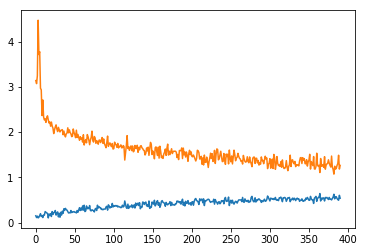

In [11]:
x = np.arange(0,len(accuracy))
plt.plot(x,np.array(accuracy),np.array(loss))

In [22]:
t = time.time()
valacc = validateFunc(100)
print(f"{time.time()-t:2.4f}\nacc {np.mean(valacc):.7f}")

85.4730
acc 0.5092959


#### DenseNet

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


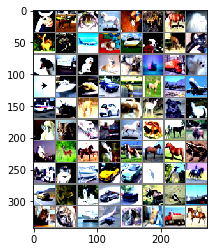

In [13]:
imshow(torchvision.utils.make_grid(images))

In [14]:
densenet = models.densenet161()